# 太陽光のスペクトルの測定

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams["figure.figsize"]=(8,4)

## 太陽光測定データ

まず太陽光の測定データを読み込もう。これは 横640 x 縦480 ピクセルの明るさデータである。

In [2]:
dsun = np.array(pd.read_csv("sun_10us_0502.txt"))

In [3]:
dsun

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [4]:
np.shape(dsun) # dsunの形状: 480行、640列

(480, 640)

画像っぽく表示するには、matplotlib.pyplot.imshow() 関数を用いて以下のようにする。引数の cmap では[カラーマップ](https://matplotlib.org/stable/tutorials/colors/colormaps.html) の種類を選んでいる。ここでは白いところに光が来ている。

In [5]:
# 後でまた使うので関数にした
def show_image(data):
    plt.imshow(data, origin="lower", cmap="gray", aspect="auto")
    plt.colorbar(label="count", pad=0.02) # 右にカラーバーを表示、padは間隔の調節
    plt.xlabel("pixel column number $x$") # columnは列
    plt.ylabel("pixel row number $y$");   # rowは行

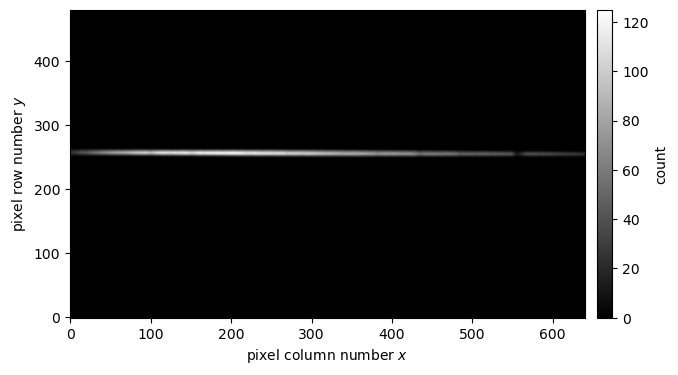

In [6]:
show_image(dsun)

column number $x$が波長方向に対応している。行（$y$）方向については和をとろう。2次元配列の和も numpy.sum() で計算できる:

In [7]:
np.sum(dsun)

339585

が上のようにすると全てのピクセルが足されてしまう。今やりたいことは、「480行（0番目のindex）についてのみ和をとり、640列（1番目のindex）については和をとらない」という操作である。これは次のようにするとできる。

In [8]:
solar_flux = np.sum(dsun, axis=0)

axis=0 は、0番目のindexについて和をとることを指定している（0から数えることに注意）。結果がちゃんと長さ640の配列になっていることを確認しよう。

In [9]:
len(solar_flux)

640

結果をcolumn number x（x方向のピクセル数）に対してプロットしよう。ピクセル数を表す配列 xpixel を新たに定義する。

In [10]:
xpixel = np.arange(640)

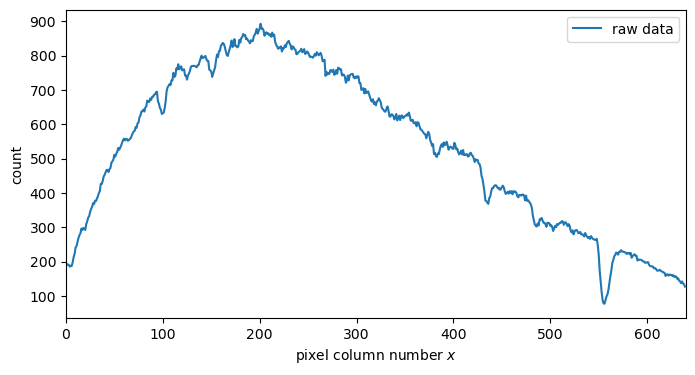

In [11]:
plt.plot(xpixel, solar_flux, label="raw data")
plt.xlabel("pixel column number $x$")
plt.ylabel("count")
plt.xlim(0, 640)
plt.legend(loc="upper right");

スペクトルらしくなってきた。ただこのデータには、

1. 横軸が物理的な波長になっていない（波長較正が行われていない）

2. 縦軸も較正されていない: 装置の測定効率が波長ごとに異なる（特に回折格子の効率とカメラの反応率の影響が大きい）ため、ここで得た強度分布は実際のものと異なる

という問題がある。以下でこれらの補正を行う。

## 波長較正

波長較正には、500nm, 650nm, 800nm の単色光の測定データを用いる。

In [12]:
calibration_wavelength = np.array([500, 650, 800])

読み込んでプロットしてみよう。

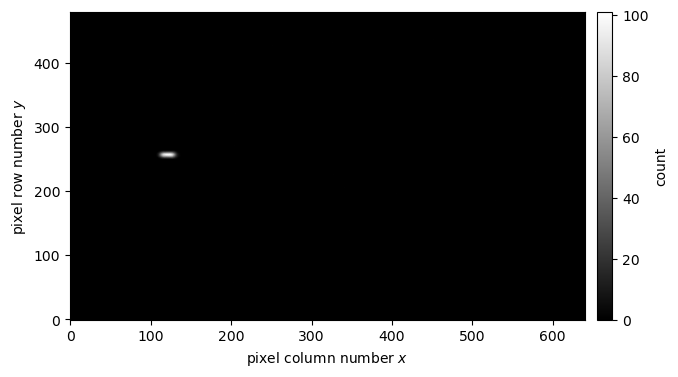

In [13]:
d500 = pd.read_csv("500nm_10000us.txt")
show_image(d500)

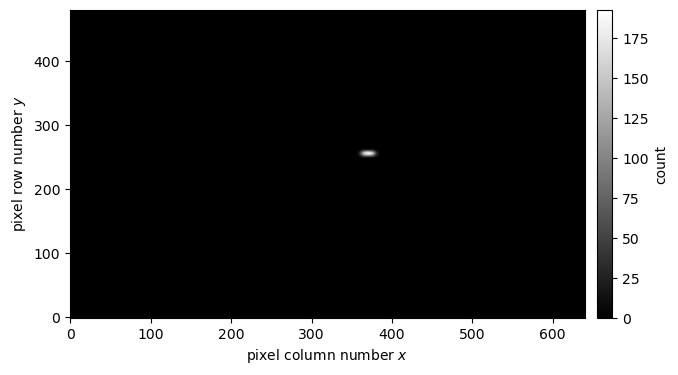

In [14]:
d650 = pd.read_csv("650nm_10000us.txt")
show_image(d650)

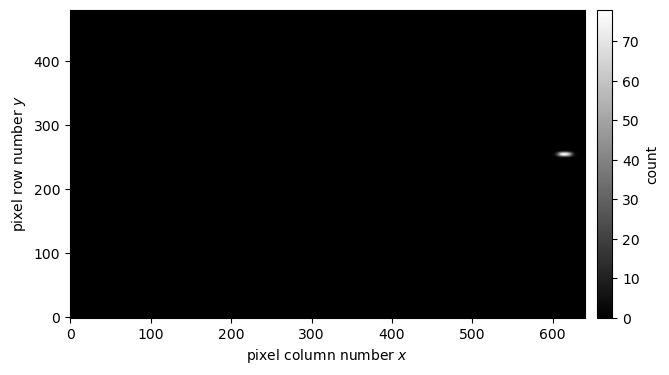

In [15]:
d800 = pd.read_csv("800nm_10000us.txt")
show_image(d800)

単色光の波長が変わると位置が動いていくのが見える。太陽光のデータと同様にy方向については和をとり、x方向のピクセル数の関数としてプロットしてみよう。

In [16]:
# 上と同様に行のみで和をとる
flux500 = np.sum(d500, axis=0)
flux650 = np.sum(d650, axis=0)
flux800 = np.sum(d800, axis=0)

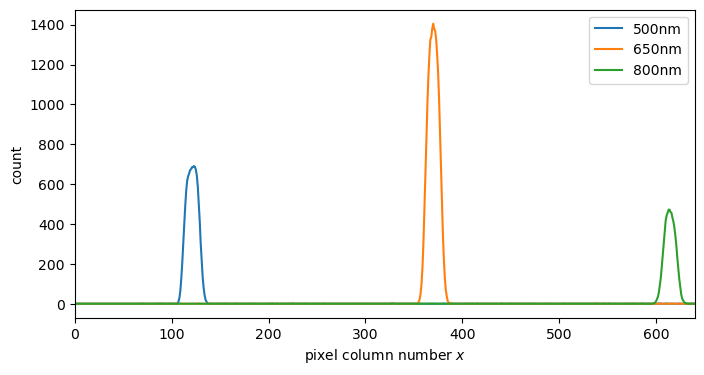

In [17]:
plt.xlabel("pixel column number $x$")
plt.ylabel("count")
plt.xlim(0, 640)
plt.plot(xpixel, flux500, label="500nm")
plt.plot(xpixel, flux650, label="650nm")
plt.plot(xpixel, flux800, label="800nm")
plt.legend(loc="upper right");

各単色光の対応するピクセル位置を求めるために、countが最大となるxを求めよう。numpy.argmax()を使うとできる。例えば、

In [18]:
test = np.array([1, 2, 4, 3, -5])

は2番目の要素（0から数えていることに注意）が一番大きい。numpy.argmax()はこの要素のindexを与える。

In [19]:
np.argmax(test)

2

この方法で、500nm, 650nm, 800nmの単色光のピクセル位置からなる配列 calibration_x を定義しよう。

In [20]:
# 各単色光のピークに対応するx方向のピクセル位置の配列を作成
calibration_x = [xpixel[np.argmax(flux500)], xpixel[np.argmax(flux650)], xpixel[np.argmax(flux800)]]

縦軸に波長（calibration_wavelength）、横軸に単色光のピクセル位置（calibration_x）をとって測定点をプロットしてみよう。ほぼ直線状になるはずである。

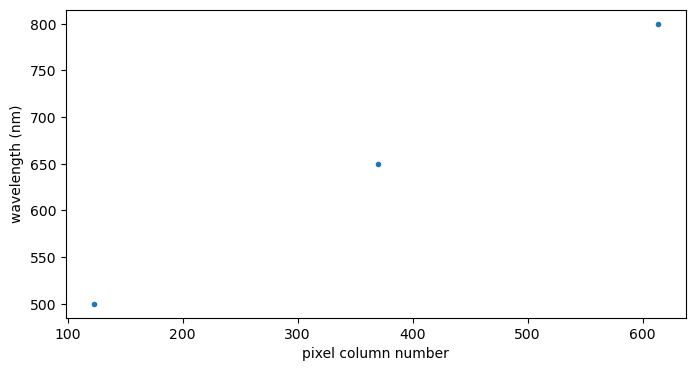

In [21]:
plt.ylabel("wavelength (nm)")
plt.xlabel("pixel column number")
plt.plot(calibration_x, calibration_wavelength, '.')

$Y$を波長、$X$をx方向のピクセル位置として、この3つの測定点から波長較正関係式 $Y=aX+b$ を最小二乗法で決定しよう。過去の課題で作ったプログラムを使ってもよいし、[numpy.polyfit](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html)　が使えればそれでもよい。

In [22]:
# a, bを計算する
a, b = np.polyfit(calibration_x, calibration_wavelength, deg=1)

In [23]:
a,b

(0.6122312984856643, 424.29072795828495)

計算できたら、a,bの値を使って直線を引いてデータと合うことを必ず確認する。

<>:2: SyntaxWarning: invalid escape sequence '\ '
<>:2: SyntaxWarning: invalid escape sequence '\ '
/var/folders/qp/91qlh0v11sb02z6vb4nb_s0m0000gn/T/ipykernel_82990/2800206553.py:2: SyntaxWarning: invalid escape sequence '\ '
  plt.plot(xpixel, a*xpixel+b, label=f"$y=ax+b\ (a={a:.3f}, b={b:.3f})$")


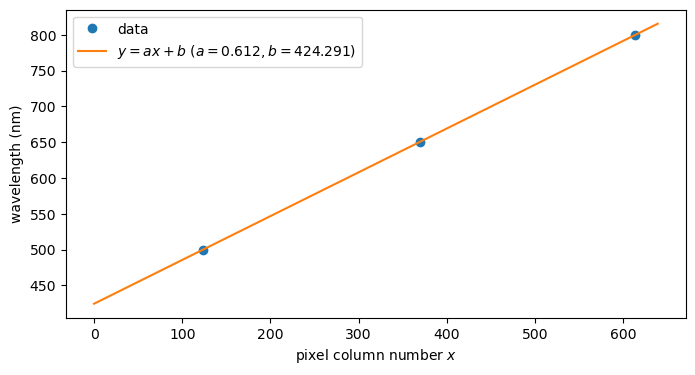

In [26]:
plt.plot(calibration_x, calibration_wavelength, 'o', label="data")
plt.plot(xpixel, a*xpixel+b, label=f"$y=ax+b\ (a={a:.3f}, b={b:.3f})$")
plt.xlabel("pixel column number $x$")
plt.ylabel("wavelength (nm)")
plt.legend(loc="best");

これで波長較正ができた。wav に波長の配列を作ろう。**wavはこの装置で取得した全てのデータで共通である。**

In [27]:
wav = a * xpixel + b

横軸を波長にした太陽光データもプロットしておこう。

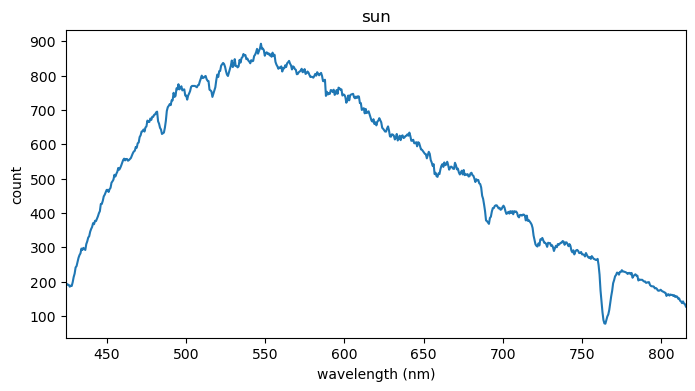

In [29]:
plt.xlim(wav[0], wav[-1]) # wavの範囲に揃えた; wav[-1]はwavの最後の要素
plt.plot(wav, solar_flux)
plt.title("sun")
plt.xlabel("wavelength (nm)")
plt.ylabel("count");

## 強度の較正

次に強度の較正を行う。ここでは、[ある温度（ここでは2800K）の黒体放射スペクトルを供給するように作られた光源](https://www.thorlabs.co.jp/newgrouppage9.cfm?objectgroup_id=7269)のスペクトルを同じ装置で取得し、得られたスペクトルと2800Kの黒体放射スペクトルを比較することで装置の効率を波長の関数として決定する。(得られたスペクトル) = (装置の効率) x (2800Kのプランク分布) なので、得られたスペクトルとプランク分布の比をとればよい。

この光源の測定結果がlamp_200us.txtである。

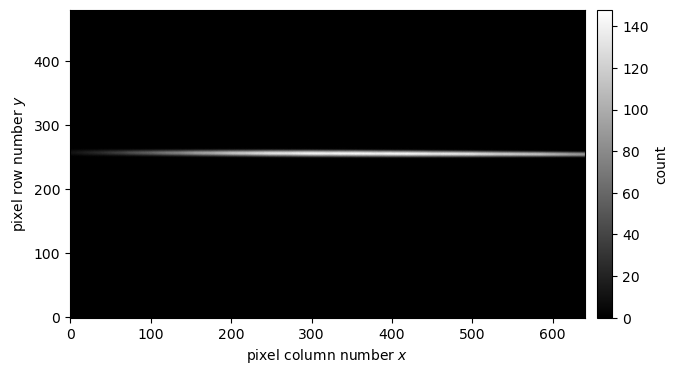

In [30]:
dlamp = pd.read_csv("lamp_200us.txt")
show_image(dlamp)

xについて和を取ろう。ここでは処理がしやすいように最大値で割って規格化しておく。

In [31]:
flux_lamp = np.sum(dlamp, axis=0)

In [32]:
flux_lamp /= np.max(flux_lamp) # flux_lampの最大値でflux_lampを割る; flux_lamp = flux_lamp / np.max(flux_lamp)と同じ

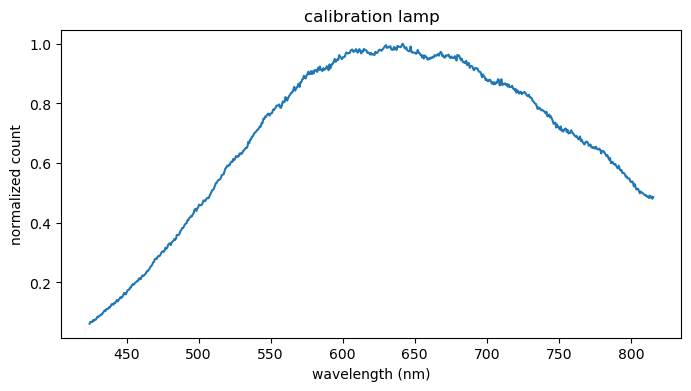

In [33]:
plt.plot(wav, flux_lamp)
plt.title("calibration lamp")
plt.xlabel("wavelength (nm)")
plt.ylabel("normalized count");

nm単位の波長wav_nmと絶対温度Tを引数にとり、プランク分布の値（最大値で割ったもの）を出力する関数 planck_func(wav_nm, T)を作成し、teff=2800の結果を上のグラフと重ねてプロットしよう。装置の効率が波長に依存するため、両者の形状は異なるはずである。flux_lamp を planck_func(wav, 2800)で割ったものが装置の効率（の相対値）を与える。これを配列 relative_efficiency として定義しよう。

**ヒント:** 例えば$x$を波長（nm）として
$$
f(x, T) = {x^2 \over T}
$$
という関数であれば、以下のようにすればよい。

In [35]:
def f(x, T):
    y = x**2 / T
    return y / np.max(y) # 最大値で割り算する

もちろんプランク分布の関数形はこれとは異なる。用いるべき関数の式はlecture-2.pdfの33ページなどにある。定数の値は自分で調べること。[ヒントはここまで]

In [36]:
def planck_func(wav, T):
    """プランク関数の値を計算する関数を作成

        引数:
            wav: 波長の配列（単位をどうするか考える）
            T: 温度（K）

        返値:
            wavと同じ長さのIの配列
    
    """
    wav_m = wav * 1e-9 # 引数wavがnm単位と想定し、mに変換
    h = 6.6260701e-34 
    k = 1.380649e-23 
    c = 2.99792458e8
    
    x = h * c / (wav_m * k * T) # ( ) を忘れずに
    I = 2 * h * c**2 / (np.exp(x) - 1) / wav_m**5 # np.exp()で指数関数が計算できる。
    return I / np.max(I)

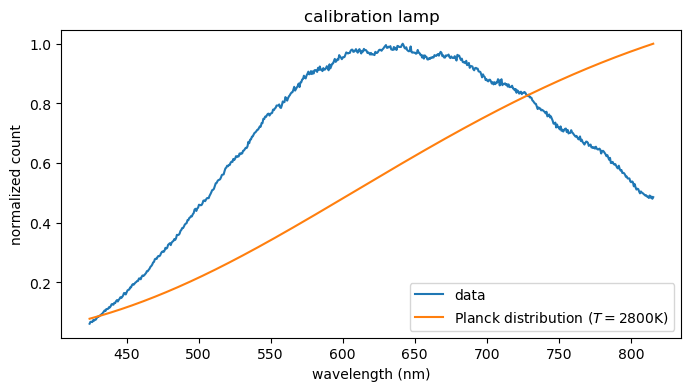

In [38]:
plt.plot(wav, flux_lamp, label='data')
plt.plot(wav, planck_func(wav, 2800), label='Planck distribution ($T=2800$K)')
plt.title("calibration lamp")
plt.xlabel("wavelength (nm)")
plt.ylabel("normalized count")
plt.legend(loc='best')

In [40]:
# 上の説明に従って計算; もとのプランク分布 x 効率 = 測定値　なので、測定値をプランク分布で割る
relative_efficiency = flux_lamp / planck_func(wav, 2800)

これで装置の効率が得られた。はじめに求めた solar_flux は、本来の太陽光スペクトルに装置の効率がかけ算されたものである。よって、solar_flux を relative_efficiency で割り算すると、強度が較正されたスペクトルが得られる。ここでも最大値を1に規格化しておこう。

In [41]:
# 上の説明に従って計算
calibrated_solar_flux = solar_flux / relative_efficiency

In [42]:
calibrated_solar_flux /= np.max(calibrated_solar_flux)

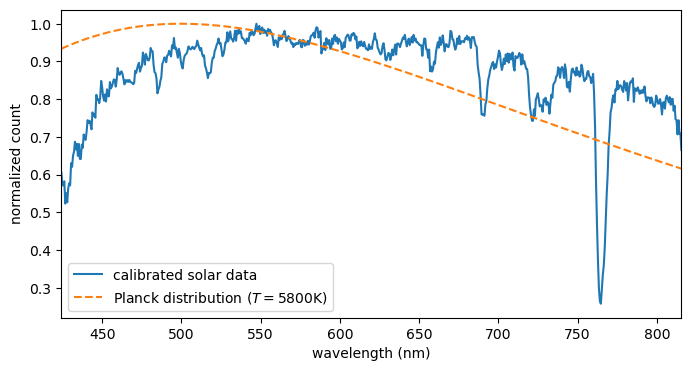

In [45]:
plt.xlim(wav[0], wav[-1])
plt.xlabel("wavelength (nm)")
plt.ylabel("normalized count")
plt.plot(wav, calibrated_solar_flux, label="calibrated solar data")
plt.plot(wav, planck_func(wav, 5800), label='Planck distribution ($T=5800$K)', ls='dashed')
plt.legend(loc="lower left");

提出課題はここまで。以下はやらなくてもよい。

## 地球大気による散乱の補正（課題の範囲外）

上のプロットに例えば planck_func(wav, 5800)　を書き加えるなどして、得られた較正済みデータの形状を太陽の表面温度に近いプランク分布と比較してみよう。近い形状に**ならない**はずである。少なくとも一つの要因は、太陽光が地球大気を通過する際の散乱の影響を補正していないことである（短波長の光ほど散乱されやすいので、地上で測定される光量が減る）。

この補正は、太陽を観測した時刻や大気の状態にも依存するので一般には困難である。ここでは理科年表に載っている値（天文部80「大気の減光」;　第80冊154ページ）を使ってとりあえずの補正を試みてみよう。データは transmittance.txt に入っている。wavが波長（nm）、transが各波長における大気の透過率（100%が1）を表す。

In [46]:
dtrans = pd.read_csv("transmittance.txt")

このデータは特定の波長でしか与えられていないので、内挿しよう。波長を横軸、透過率を縦軸にプロットしてみるとわかるように、明らかに1次関数ではうまくいかない。ここでは [scipy.interpolate.interp1d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d) を使ってみよう。transmittance = interp1d(x, y, kind="cubic") などとすると、x,yを内挿する関数transmittanceが得られる。kindは内挿の方法（ただ線でつなぐか、何らかの方法で"滑らかに"つなぐか、など）を指定している。**内挿なので、transmittanceの引数にxの範囲より広い値を入れるとエラーが出る**ことに注意。

In [47]:
from scipy.interpolate import interp1d

In [48]:
dtrans

,wav,trans
0,300,0.010
1,320,0.275
2,360,0.510
3,400,0.630
4,500,0.790
5,600,0.840
6,800,0.940
7,1000,0.960


In [49]:
# interp1dを使って関数を作る
transmittance = interp1d(dtrans.wav, dtrans.trans, kind='cubic')

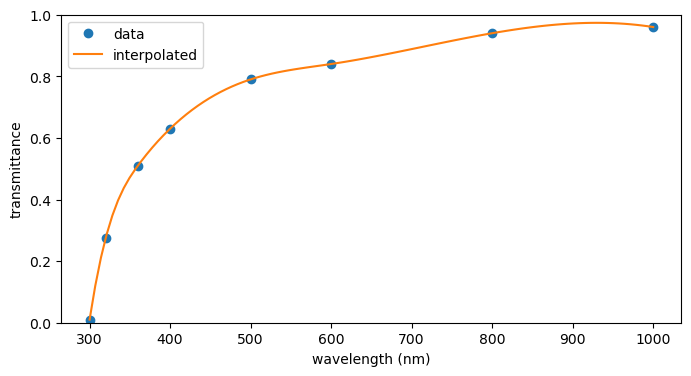

In [53]:
# 作った関数をプロットする。透過率のデータも重ねてプロットし、内挿する関数が上手く作れていることを確認しよう。
x = np.linspace(300, 1000, 100)
plt.ylabel("transmittance")
plt.xlabel("wavelength (nm)")
plt.ylim(0, 1)
plt.plot(dtrans.wav, dtrans.trans, 'o', label="data")
plt.plot(x, transmittance(x), label="interpolated")
plt.legend(loc="best")

上で得たcalibrated_solar_fluxをtransmittance(wav)で割ったものをプロットし、再度Planck分布と比較してみよう。

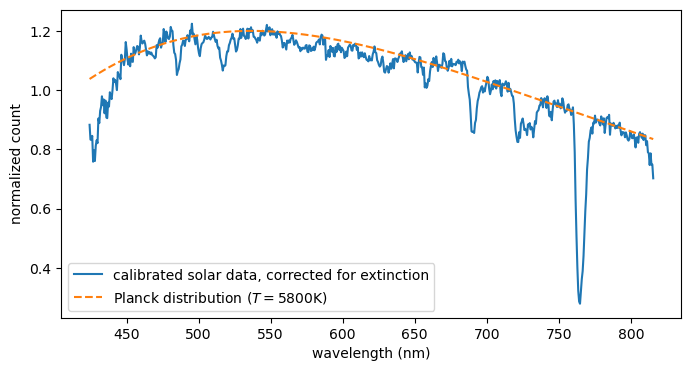

In [56]:
plt.xlabel("wavelength (nm)")
plt.ylabel("normalized count")
plt.plot(wav, calibrated_solar_flux / transmittance(wav), label="calibrated solar data, corrected for extinction")
plt.plot(wav, planck_func(wav, 5400)*1.2, ls='dashed', label='Planck distribution ($T=5800$K)') # 1.2は適当
plt.legend(loc="lower left");

このデータの場合、温度が5400K程度であればそれなりに近い形のスペクトルになるはずである。上述のようにここで行った散乱の補正は簡易的なものであり、また散乱以外に特定波長で生じる吸収の影響もある（こちらは補正していない）ので、地上からの測定で正確なエネルギー分布を得るのは大変である。